In [1]:
from load_data import * 
from helpers import mtanh, calculate_pressure, normal_distribution, calculate_bohmgyrbohm_particlediffusion, TransParams, solve_pde, T_model, n_model, get_chi_inter, get_d_inter, get_chi_inter_unscaled, get_d_inter_unscaled, BCS, solve_time_evolution, calculate_bohmgrybohm_from_jardin, calculate_bohmdiffusion
from helpers import p_chi, r_chi, ode_system 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import scienceplots 
import os 
import sys 
plt.style.use(['science', 'grid'])

from scipy.signal import find_peaks
from tqdm.notebook import tqdm 

In [3]:
BASE_PULSE_DIR = "/home/akadam/EUROfusion/2024/data"
shot_num = 83627 # 83624 # 
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")
JET_PDB_DIR = "/home/akadam/EUROfusion/2024/data"

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

""" Plotting of crash """
if shot_num == 83624:
    offset = 0.046
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83625:
    offset = 0.041
elif shot_num == 83627:
    offset = 0.043
else: 
    offset = 0.0


te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)

N_POINTS    = 1000
R           = np.linspace(machineparams.Rmaj, machineparams.Rmaj + machineparams.Rmin, N_POINTS)
phi         = R**2
phi_norm    = (phi - phi.min()) / (phi.max() - phi.min())
pedestal_region =  phi_norm > 0.65
phi_norm    = phi_norm[pedestal_region]
phi         = phi[pedestal_region]
R           = R[pedestal_region]
dphi_normdr = 2*R / (phi.max() - phi.min())


steady_state_te = mtanh(phi_norm, te_fit_params.h1, te_fit_params.h0, te_fit_params.s, te_fit_params.w, te_fit_params.p)
steady_state_ne = mtanh(phi_norm, ne_fit_params.h1, ne_fit_params.h0, ne_fit_params.s, ne_fit_params.w, ne_fit_params.p)
steady_state_pe = mtanh(phi_norm, pe_fit_params.h1, pe_fit_params.h0, pe_fit_params.s, pe_fit_params.w, pe_fit_params.p)
# print(te_fit_params.h1, ne_fit_params.h1, pe_fit_params.h1)

# Finding ELM timings 
normed_tbeo = (pulse.tbeo.data - pulse.tbeo.data.mean() ) / pulse.tbeo.data.std()
delta_t = pulse.tbeo.time[1] - pulse.tbeo.time[0]
distance_between_elms = int(200E-6 / delta_t)*20
threshold_height = normed_tbeo.std()*2
peaks, _ = find_peaks(normed_tbeo, height=threshold_height, distance=distance_between_elms)
adjusted_peaks = np.empty_like(peaks)
# TODO: SHIFT THE TBEO SIGNAL BY SOME TIME 
for i, pk in enumerate(peaks): 
    for k in range(30): 
        if normed_tbeo[pk - k] < 0: 
            zero_crossing = pk-k 
            break 
        else: 
            zero_crossing = pk 
    adjusted_peaks[i] = zero_crossing


elm_times = pulse.tbeo.time[peaks]

elm_frequency = len(peaks) / (pulse.tbeo.time[-1] - pulse.tbeo.time[0])
t_minus_t_elm = np.empty(len(relevant_profiles.hrts_times))
for i, t in enumerate(relevant_profiles.hrts_times):
    nearest_elm_idx = np.argmin(np.abs(elm_times - t))
    t_nearest_elm = elm_times[nearest_elm_idx]    
    t_minus_t_elm[i] = t - t_nearest_elm

chi_gb, gyroradius = calculate_bohmgrybohm_from_jardin(R, phi, phi_norm, steady_state_te, machineparams)
Dbohm = calculate_bohmdiffusion(steady_state_te, machineparams)
Dbohmgb = calculate_bohmgyrbohm_particlediffusion(steady_state_te, machineparams)


In [82]:
# setup inter-ELM crash 
CHI0_INTRA = chi_gb[0]    
D0_INTRA   = Dbohm[0]

C_CRASH =  1.4559 # scan_crashes[best_c_crash_idx] #  
intra_params = TransParams(
        CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_CRASH, CHI0_INTRA*2.0), # np.ones_like(phi_norm),
        D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_CRASH , D0_INTRA*5.0), # np.ones_like(phi_norm),
        V=np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_CRASH,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INSIDE_FIXED, 
        dphi_normdr=dphi_normdr,
        mps = machineparams
    )

intra_params.heatfluxin   = phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
intra_params.te_inner_lim = 0.0

intra_params.particlefluxin = (Dbohm[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
intra_params.particlefluxout = (intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]    
intra_params.ne_inner_lim = 0.0 # max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
intra_params.ne_outer_lim = 0.3*steady_state_ne[-1] #  * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3

# Setup inter-ELM growth

CHI0_INTER = chi_gb[0]*0.30 # Factor 0.3 USED TO MATCH THE NE GROWTH, MORE OR LESS. 
D0_INTER   = Dbohm[0]*1.25

C_GROWTH = 2.35

C_INTER_INITIAL = -0.05
C_INTER_OVER_TIME = lambda t, cinter: C_INTER_INITIAL + (cinter + C_INTER_INITIAL)*t


tstep_post_elmcrash = 0.0
inter_params = TransParams(
        CHI=np.empty_like(phi_norm), # normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_INTER_OVER_TIME(tstep, C_INTER), CHI0_INTRA*2.0), # np.ones_like(phi_norm),
        D=np.empty_like(phi_norm), #normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_INTER_OVER_TIME(tstep, C_INTER), D0_INTRA*5.0), # np.ones_like(phi_norm),
        V=phi_norm**5, # np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_INTER_OVER_TIME(tstep_post_elmcrash, C_GROWTH),
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INSIDE_FIXED, 
        dphi_normdr=dphi_normdr,
        mps = machineparams
    )



In [84]:
current_time = 0.0
tstep_post_elmcrash = 0.0

in_pedestal = phi_norm > 0.94
ALPHA_CRIT = np.max(abs(np.gradient(steady_state_pe, phi_norm))) # - 0.5

IN_ELM_PHASE = True 
T_SINCE_LAST_ELM   = 0.0
current_t = steady_state_te
current_n = steady_state_ne
current_p = calculate_pressure(steady_state_te, steady_state_ne)

tau_intraelm     = 200E-6 # 200 us
tau_interelm = 0.00001
total_t_interval = [0, 0.5]
NUM_TIME_TO_KEEP = int(total_t_interval[1] / (min(tau_intraelm, tau_interelm) / 2.0))

total_t_keep     = np.linspace(total_t_interval[0], total_t_interval[1], NUM_TIME_TO_KEEP) 
elm_times = []
collection = []
while (current_time < total_t_interval[1]): 
    # if alpha > ALPHA_CRIT then we are in the ELM phase
    alpha = np.max(abs(np.gradient(current_p[in_pedestal], phi_norm[in_pedestal])))
    if alpha >= ALPHA_CRIT and T_SINCE_LAST_ELM >= 2*tau_intraelm:
        IN_ELM_PHASE = True 
        elm_times.append(current_time)
    # If not, we are in the inter-ELM phase
    if not IN_ELM_PHASE:  # inter-ELM phase
        # Move a small time step forward, tau_interelm
        dt = tau_interelm
        t_internal      = [current_time, current_time + dt]
        t_keep_internal = total_t_keep[np.where((total_t_keep >= t_internal[0]) & (total_t_keep <= t_internal[1]))[0]]
        tstep = T_SINCE_LAST_ELM 
        # t_keep_internal = np.linspace(t_internal[0], t_internal[1], 10)
        # tstep = total_t_interval[0] + (total_t_interval[1] - total_t_interval[0]) / 2.0

        inter_params._C = C_INTER_OVER_TIME(tstep, C_GROWTH)
        inter_params.CHI =  get_chi_inter(phi_norm, CHI0_INTER, steady_state_te, inter_params)
        inter_params.D   = get_d_inter(phi_norm, D0_INTER, steady_state_ne, inter_params)
        inter_params.heatfluxin   = -(phi_norm[0]*(CHI0_INTER)*np.gradient(steady_state_te, phi_norm)[0])
        inter_params.te_inner_lim = max(steady_state_te)
        
        inter_params.particlefluxin = -((D0_INTER*5)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + inter_params.V[0]*steady_state_ne[0])
        inter_params.particlefluxout = -((D0_INTER*5)*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + inter_params.V[-1]*steady_state_ne[-1])
        inter_params.ne_inner_lim = max(steady_state_ne) 
        inter_params.ne_outer_lim = steady_state_ne[-1] 

        solutions_interelm_te = solve_pde(phi_norm, current_t, t_internal, inter_params, T_model, t_keep_internal)
        solutions_interelm_ne = solve_pde(phi_norm, current_n, t_internal, inter_params, n_model, t_keep_internal)

        current_t = solutions_interelm_te[:, -1]
        current_n = solutions_interelm_ne[:, -1]
        T_SINCE_LAST_ELM += dt

    else: # INTRA-ELM PHASE
        dt = tau_intraelm
        tstep = total_t_interval[0] + (total_t_interval[1] - total_t_interval[0]) / 2.0
        t_internal      = [current_time, current_time + dt]
        t_keep_internal = total_t_keep[np.where((total_t_keep >= t_internal[0]) & (total_t_keep <= t_internal[1]))[0]]
        solutions_intraelm_te = solve_pde(phi_norm, current_t, t_internal, intra_params, T_model, t_keep_internal)
        solutions_intraelm_ne = solve_pde(phi_norm, current_n, t_internal, intra_params, n_model, t_keep_internal)

        current_t = solutions_intraelm_te[:, -1]
        current_n = solutions_intraelm_ne[:, -1]
        IN_ELM_PHASE = False 
        T_SINCE_LAST_ELM = 0.0
    current_p = calculate_pressure(current_t, current_n)
    current_time += dt 

    collect = (current_time, intra_params, inter_params, t_keep_internal, current_t, current_n, current_p, T_SINCE_LAST_ELM)
    collection.append(collect)
    print(f'Sim Time: {current_time:.3}, ELM Phase: {IN_ELM_PHASE}, alpha: {alpha:.3}, TSINCELASTELM: {T_SINCE_LAST_ELM:.3}, CHI_VAL: {inter_params._C:.3}')

Sim Time: 0.0002, ELM Phase: False, alpha: 94.8, TSINCELASTELM: 0.0, CHI_VAL: -0.05
Sim Time: 0.00021, ELM Phase: False, alpha: 31.8, TSINCELASTELM: 1e-05, CHI_VAL: -0.05
Sim Time: 0.00022, ELM Phase: False, alpha: 32.8, TSINCELASTELM: 2e-05, CHI_VAL: -0.05
Sim Time: 0.00023, ELM Phase: False, alpha: 30.7, TSINCELASTELM: 3e-05, CHI_VAL: -0.05
Sim Time: 0.00024, ELM Phase: False, alpha: 30.1, TSINCELASTELM: 4e-05, CHI_VAL: -0.0499
Sim Time: 0.00025, ELM Phase: False, alpha: 29.9, TSINCELASTELM: 5e-05, CHI_VAL: -0.0499
Sim Time: 0.00026, ELM Phase: False, alpha: 30.2, TSINCELASTELM: 6e-05, CHI_VAL: -0.0499
Sim Time: 0.00027, ELM Phase: False, alpha: 30.4, TSINCELASTELM: 7e-05, CHI_VAL: -0.0499
Sim Time: 0.00028, ELM Phase: False, alpha: 30.6, TSINCELASTELM: 8e-05, CHI_VAL: -0.0498
Sim Time: 0.00029, ELM Phase: False, alpha: 30.8, TSINCELASTELM: 9e-05, CHI_VAL: -0.0498
Sim Time: 0.0003, ELM Phase: False, alpha: 31.0, TSINCELASTELM: 0.0001, CHI_VAL: -0.0498
Sim Time: 0.00031, ELM Phase: Fa

KeyboardInterrupt: 

In [85]:
# Process collection into arrays, time_all (current_times), temp_all, density_all, pressure_all 
time_all = np.empty(len(collection))
temp_all, density_all, pressure_all = np.empty((len(collection), len(phi_norm))), np.empty((len(collection), len(phi_norm))), np.empty((len(collection), len(phi_norm)))
for i, collect in enumerate(collection): 
    time_all[i] = collect[0]
    temp_all[i] = collect[4]
    density_all[i] = collect[5]
    pressure_all[i] = collect[6]

In [86]:
# Determine the ELM frequency, by looping over windows of 0.3 seconds and coutning number of ELM hits, and averaging over the windows


ALPHA_EXP = np.max(abs(np.gradient(pressure_all[:, in_pedestal], phi_norm[in_pedestal], axis=1)), axis=1)

ELM_HITS =  ALPHA_EXP > ALPHA_CRIT

elm_freqs = [] 
windows = [(i+0.1, i+0.3) for i in np.arange(0, 1.5, 0.2)]
for window in windows: 
    twindow_idx = np.where((time_all >= window[0]) & (time_all <= window[1]))[0]
    n_elm_hits  = np.sum(ELM_HITS[twindow_idx])
    elm_freqs.append(n_elm_hits / (window[1] - window[0]))

avg_elm_freq = np.mean(elm_freqs)
std_elm_freq = np.std(elm_freqs)

# calculate tau_interelm from looking at time between ELMS
elm_times_sim = time_all[ELM_HITS]
tau_interelm_sim = [] 
for i in range(len(elm_times_sim) - 1): 
    tau_interelm_sim.append(elm_times_sim[i+1] - elm_times_sim[i])

print(elm_times_sim[0], elm_times_sim[1], elm_times_sim[1] - elm_times_sim[0])

print(np.mean(tau_interelm_sim))


0.03772000000000088 0.07465000000000369 0.03693000000000281
0.035158750000022054


30.0


(0.0, 10.0)

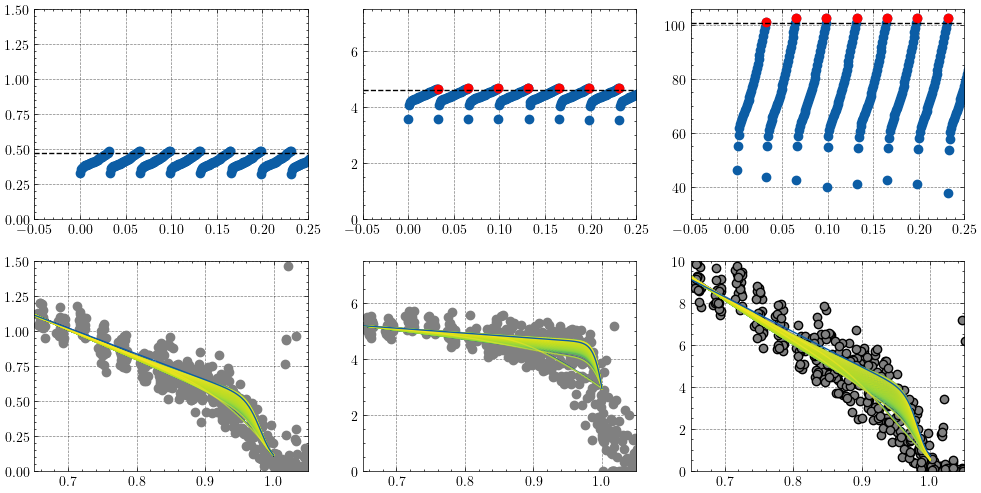

In [69]:
ped_idx_ne = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
ped_idx_te = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))


fig, axs = plt.subplots(2, 3, figsize=(12, 6))

axs = axs.ravel()

axs[0].scatter(time_all, temp_all[:, ped_idx_te], label='Pedestal')
axs[1].scatter(time_all, density_all[:, ped_idx_ne], label='Pedestal')   
axs[1].scatter(time_all[ELM_HITS], density_all[ELM_HITS, ped_idx_ne], color='red', label='ELM hits')
axs[2].scatter(time_all, np.max(abs(np.gradient(pressure_all[:, in_pedestal], phi_norm[in_pedestal], axis=1)), axis=1), label='Pedestal')
axs[2].scatter(time_all[ELM_HITS], ALPHA_EXP[ELM_HITS], color='red', label='ELM hits')
twindow = [0.0, 0.2]

twindow_idx = np.where((time_all >= twindow[0]) & (time_all <= twindow[1]))[0]
# Number of ELM hits within time window
n_elm_hits = np.sum(ELM_HITS[twindow_idx])
# ELM freq in time window 
elm_freq = n_elm_hits / (twindow[1] - twindow[0])
print(elm_freq)

# Calculate times between elm hits 
for k in range(len(ELM_HITS)): 
    if ELM_HITS[k]: 
        print(f'ELM hit at time: {time_all[k]:.4}')

    break 
for i in twindow_idx:
    color = plt.cm.viridis((time_all[i] - twindow[0]) / (twindow[1] - twindow[0]))
    axs[3].plot(phi_norm, temp_all[i], alpha=0.5, color=color)
    axs[4].plot(phi_norm, density_all[i], alpha=0.5, color=color)
    axs[5].plot(phi_norm, pressure_all[i], alpha=0.5, color=color)

for ax in axs[:3]: 
    ax.set_xlim(twindow[0] - 0.05, twindow[1] + 0.05)

for ax in axs[3:]:
    ax.set_xlim(phi_norm.min(), phi_norm.max() + 0.05)
axs[3].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey')
axs[4].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey')
axs[5].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')

axs[3].plot(phi_norm, steady_state_te, label='Steady state')
axs[4].plot(phi_norm, steady_state_ne, label='Steady state')
axs[5].plot(phi_norm, steady_state_pe, label='Steady state')

axs[0].axhline(steady_state_te[ped_idx_te], color='black', linestyle='--')
axs[1].axhline(steady_state_ne[ped_idx_ne], color='black', linestyle='--')
axs[2].axhline(ALPHA_CRIT, color='black', linestyle='--')
for ax in [axs[3], axs[0]]:
    ax.set_ylim(0.0, 1.5)
for ax in [axs[4], axs[1]]:
    ax.set_ylim(0.0, 7.5)
axs[5].set_ylim(0, 10)

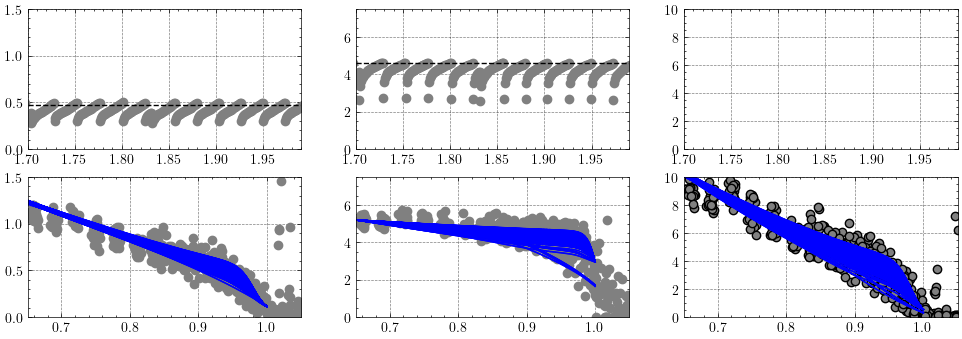

In [50]:
ped_idx_ne = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
ped_idx_te = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))

fig, axs = plt.subplots(2, 3, figsize=(12, 4))

axs = axs.ravel()
for n, collect in enumerate(collection): 
    current_time, intra_params, inter_params, t_keep_internal, current_t, current_n, current_p, T_SINCE_LAST_ELM = collect
    # plt.plot(phi_norm, current_t, label=f'{current_time:.3}')
    axs[2].scatter(current_time, np.max(abs(np.gradient(current_p, phi_norm))), color='r')
    axs[0].scatter(current_time, current_t[ped_idx_te], color='grey')
    axs[1].scatter(current_time, current_n[ped_idx_ne], color='grey')

axs[2].axhline(ALPHA_CRIT, color='k', linestyle='--')
axs[0].axhline(steady_state_te[ped_idx_te], color='k', linestyle='--')
axs[1].axhline(steady_state_ne[ped_idx_ne], color='k', linestyle='--')

twindow = [1.7, 1.99]

for n, collect in enumerate(collection):
    current_time, intra_params, inter_params, t_keep_internal, current_t, current_n, current_p, T_SINCE_LAST_ELM = collect
    if current_time < twindow[0] or current_time > twindow[1]: 
        continue 
    axs[3].plot(phi_norm, current_t, label=f'{current_time:.3}', color='blue')
    axs[4].plot(phi_norm, current_n, label=f'{current_time:.3}', color='blue')
    axs[5].plot(phi_norm, current_p, label=f'{current_time:.3}', color='blue')

axs[3].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey')
axs[4].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey')
axs[5].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')

for ax in [axs[3], axs[0]]:
    ax.set_ylim(0.0, 1.5)
for ax in [axs[4], axs[1]]:
    ax.set_ylim(0.0, 7.5)
axs[5].set_ylim(0, 10)

for ax in axs[3:]: 
    ax.set_xlim(phi_norm.min(), 1.05)
for ax in axs[:3]: 
    ax.set_xlim(twindow[0], twindow[1])
plt.show()